In [9]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *
from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.linear_model import LinearRegression # Logistic Regression Model
from sklearn.metrics import mean_squared_error, r2_score #model evaluation

from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans # k-means
from sklearn.mixture import GaussianMixture # EM/GMM
from sklearn.cluster import AgglomerativeClustering # hierarchical agglomerative clustering
from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture


%matplotlib inline

In [3]:
df = pd.read_csv("Activities-2.csv")
df.columns

Index(['Activity Type', 'Date', 'Favorite', 'Title', 'Distance', 'Calories',
       'Time', 'Avg HR', 'Max HR', 'Aerobic TE', 'Avg Run Cadence',
       'Max Run Cadence', 'Avg Pace', 'Best Pace', 'Elev Gain', 'Elev Loss',
       'Avg Stride Length', 'Avg Vertical Ratio', 'Avg Vertical Oscillation',
       'Avg Ground Contact Time', 'Avg GCT Balance', 'Training Stress Score®',
       'Grit', 'Flow', 'Climb Time', 'Bottom Time', 'Min Temp',
       'Surface Interval', 'Decompression', 'Best Lap Time', 'Number of Laps',
       'Max Temp'],
      dtype='object')

In [4]:
df.head()

,Activity Type,Date,Favorite,Title,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,...,Grit,Flow,Climb Time,Bottom Time,Min Temp,Surface Interval,Decompression,Best Lap Time,Number of Laps,Max Temp
0,Running,2020-11-24 07:07:08,False,San Jose ML13,13.00,"1,092",02:01:20,138,165,2.9,...,0.0,0.0,2:01:20,0:00,53.6,0:00,No,00:01.71,14,0.0
1,Running,2020-11-23 07:02:22,False,San Jose ML12,12.11,887,01:56:26,127,148,2.5,...,0.0,0.0,1:56:26,0:00,59.0,0:00,No,00:56.72,13,0.0
2,Running,2020-11-22 07:10:09,False,Hills 14,14.50,"1,319",02:26:28,137,158,3.1,...,0.0,0.0,2:26:28,0:00,55.4,0:00,No,04:36.41,15,0.0
3,Running,2020-11-21 07:07:08,False,Leland ML12,12.20,957,01:36:20,142,161,2.9,...,0.0,0.0,1:36:20,0:00,53.6,0:00,No,01:53.10,13,0.0
4,Running,2020-11-20 06:47:05,False,San Jose ML11,11.20,998,01:42:21,138,166,3.1,...,0.0,0.0,1:42:21,0:00,51.8,0:00,No,01:52.99,12,0.0


In [10]:
# convert the column of Time from "Hours:Minutes:Seconds" to "minutes" for each Time
def calc_time_minutes(times): # List of times
    conversion = [60, 1, 1/60]
    new_times = []
    for row in times:
        time_list = row.split(":")
        minutes = 0.

        # multiple the respective indeces "Hours:Minutes:Seconds" by specific
        # amount to convert to minutes
        for i, conv in zip(time_list, conversion): 
            minutes += float(i) * conv

        new_times.append(round(minutes, 3))
    return new_times

# convert the column of Avg pace from "Minutes:Seconds" to "Minutes" for each Avg Pace
def calc_avg_pace_minutes(times):
    conversion = [1, 1/60]
    new_times = []
    for row in times:
        time_list = row.split(":")
        minutes = 0.

        # multiple the respective indeces "Hours:Minutes:Seconds" by specific
        # amount to convert to minutes
        for i, conv in zip(time_list, conversion): 
            minutes += float(i) * conv
        new_times.append(round(minutes, 3))
    return new_times


# convert the column of calories for string values to int for each calorie
def calories_to_num(calories):
    return [int(calorie.replace(",", "")) for calorie in calories]

In [18]:
df = pd.read_csv("Activities-2.csv")
# df = df.drop(columns = ["Favorite", "Training Stress Score®", "Grit", "Flow", "Decompression", "Number of Laps", "Best Lap Time"])
df = df.drop(columns = ["Activity Type", "Avg Vertical Ratio", "Avg Vertical Oscillation", "Surface Interval", "Avg Ground Contact Time", "Avg GCT Balance", "Max Temp", "Favorite", "Training Stress Score®", "Grit", "Flow", "Decompression", "Number of Laps", "Best Lap Time"])

df = df.loc[df["Avg Pace"] != "--"]


# fix the Time column
# new_time_col = [calc_time_minutes(i) for i in df["Time"]]
# df["Time"] = new_time_col
# df["Time"] = [calc_time_minutes(i) for i in df["Time"]]
df["Time"] = calc_time_minutes(df["Time"])

# fix the Avg Pace column
# new_avg_pace_col = [calc_time_minutes(i) for i in df["Avg Pace"]]
# df["Avg Pace"] = new_avg_pace_col
# df["Avg Pace"] = [calc_avg_pace_minutes(i) for i in df["Avg Pace"]]
df["Avg Pace"] = calc_avg_pace_minutes(df["Avg Pace"])


# fix the Calories column
df["Calories"] = calories_to_num(df["Calories"])

# add Calories per minute
df["Calories Per Minute"] = df["Calories"] / df["Time"]
df.head()

,Date,Title,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Elev Gain,Elev Loss,Avg Stride Length,Climb Time,Bottom Time,Min Temp,Calories Per Minute
0,2020-11-24 07:07:08,San Jose ML13,13.00,1092,121.333,138,165,2.9,183,199,9.333,7:59,636,669,0.94,2:01:20,0:00,53.6,9.000025
1,2020-11-23 07:02:22,San Jose ML12,12.11,887,116.433,127,148,2.5,182,193,9.617,8:24,535,568,0.92,1:56:26,0:00,59.0,7.618115
2,2020-11-22 07:10:09,Hills 14,14.50,1319,146.467,137,158,3.1,177,195,10.100,8:30,879,837,0.90,2:26:28,0:00,55.4,9.005441
3,2020-11-21 07:07:08,Leland ML12,12.20,957,96.333,142,161,2.9,185,199,7.900,6:54,62,72,1.10,1:36:20,0:00,53.6,9.934290
4,2020-11-20 06:47:05,San Jose ML11,11.20,998,102.350,138,166,3.1,181,213,9.133,7:13,669,689,0.97,1:42:21,0:00,51.8,9.750855


In [7]:
model = LinearRegression()
cadence = ["Avg Run Cadence"]
stride = ["Avg Stride Length"]
model.fit(df[cadence], df["Avg Pace"])

y_pred = model.predict(df[cadence])
r2_score(df["Avg Pace"], y_pred)
# predictors = ["Distance", "Time", "Avg HR", "Avg Pace"]
# model.fit(df[predictors], df["Calories"])

0.5088020401869672

In [8]:
coef = pd.DataFrame({"Coefs" : model.coef_, "Predictor" : predictors })
coef = coef.append({"Coefs": model.intercept_,
                    "Predictor": "intercept"}, ignore_index = True)
coef

NameError: name 'predictors' is not defined

In [ ]:
(ggplot(df, aes (x = "Distance", y = "Calories Per Minute")) + geom_point() +
theme_minimal())

In [ ]:
(ggplot(df, aes (x = "Distance", y = "Avg Pace")) + geom_point() +
theme_minimal())

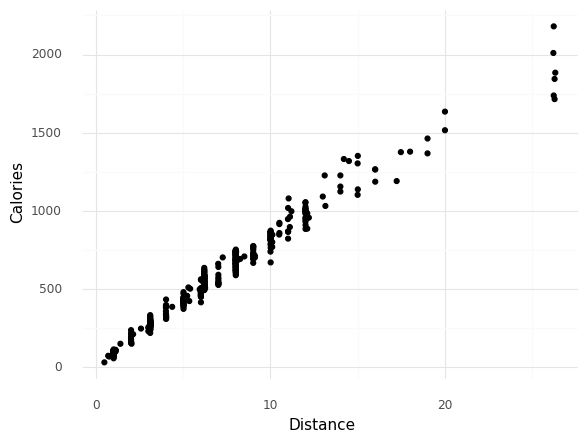

<ggplot: (8769455383273)>

In [12]:
(ggplot(df, aes (x = "Distance", y = "Calories")) + geom_point() +
theme_minimal())

In [ ]:
y_pred = model.predict(df[predictors])
r2_score(df["Calories"], y_pred)

In [ ]:
true_vs_pred = pd.DataFrame({"true_vals": df["Calories"], "pred_vals": y_pred})
true_vs_pred["residual"] = true_vs_pred["true_vals"] - true_vs_pred["pred_vals"]
(ggplot(true_vs_pred, aes (x = "true_vals", y = "pred_vals")) + geom_point() +
ggtitle("Predicted Calories vs True Calories") +
theme_minimal() +
labs(x = "Predicted Calories"))

In [ ]:
(ggplot(true_vs_pred, aes (x = "true_vals", y = "residual")) + geom_point() +
ggtitle("Predicted Calories vs Residual") +
theme_minimal() +
labs(x = "Predicted Calories"))